導入資料 初步檢查

In [12]:
import warnings
warnings.filterwarnings("ignore")  # 屏蔽 warning

%matplotlib inline

import pandas as pd

df = pd.read_csv('./dataset/train.csv')
print(df.shape)  # 输出 (行数, 列数)
print(df.head(5))

(27643, 3)
   Id  Popularity                                       Page content
0   0          -1  <html><head><div class="article-info"> <span c...
1   1           1  <html><head><div class="article-info"><span cl...
2   2           1  <html><head><div class="article-info"><span cl...
3   3          -1  <html><head><div class="article-info"><span cl...
4   4          -1  <html><head><div class="article-info"><span cl...


預處理資料

In [19]:
import re
from bs4 import BeautifulSoup
from nltk.stem.porter import PorterStemmer
import nltk
from nltk.corpus import stopwords


import re
from bs4 import BeautifulSoup

# —— 预编译：正文起始容器（出现就截断其后全部）——
_BODY_OPEN = re.compile(
    r'(?is)<\s*(section|div|article)\b[^>]*\bclass\s*=\s*(["\'])[^"\']*\b(?:article-content|article-body|content-body|post-content)\b[^"\']*\2[^>]*>'
)
# 去掉常见前置噪声（不影响我们提取标题/作者等）
_NOISE_BLOCKS = re.compile(
    r'(?is)'
    r'<(script|style|noscript|footer|aside)\b.*?</\1>'
    r'|<figure\b.*?</figure>'
    r'|<figcaption\b.*?</figcaption>'
    r'|<div[^>]*\bclass\s*=\s*(["\'])[^"\']*\b(image-credit|gallery|social|share|breadcrumb)\b[^"\']*\1[^>]*>.*?</div>'
)
# 简单的文本规范化（保留数字）
def _norm(txt: str) -> str:
    return re.sub(r'[\W]+', ' ', (txt or '').lower()).strip()

def _bucket(n, edges):
    """把数值 n 用边界列表 edges 分桶，返回桶名，例如 edges=[0,5,10] -> b0_5, b5_10, b10p"""
    if n is None:
        return 'unk'
    for i in range(len(edges)-1):
        if edges[i] <= n < edges[i+1]:
            return f"b{edges[i]}_{edges[i+1]}"
    return f"b{edges[-1]}p"

def preprocessor(html: str) -> str:
    """
    目标：保留影响“受欢迎程度”的关键信息，去掉正文。
    返回值：可直接喂给 CountVectorizer 的字符串（标题词 + 特征 token）
    """
    if not isinstance(html, str):
        html = "" if html is None else str(html)

    # 先去掉前置噪声，避免把长图说当正文保留
    html = _NOISE_BLOCKS.sub(' ', html)

    # 从正文容器起点开始，截断到文末（去正文）
    m = _BODY_OPEN.search(html)
    if m:
        html = html[:m.start()]

    # 用 Soup 解析“结构化”字段（在截断后的页眉/标题区里）
    soup = BeautifulSoup(html, 'html.parser')

    # —— 标题（最重要）——
    title = None
    # 常见位置：<h1 class="title"> 或 <h1>
    h1 = soup.find('h1', class_=lambda c: True if not c else 'title' in c if isinstance(c, list) else 'title' in str(c))
    if not h1:
        h1 = soup.find('h1')
    if h1:
        title = h1.get_text(' ', strip=True)
    elif soup.title:
        # 退化方案：<title>
        title = soup.title.get_text(' ', strip=True)
    title_tokens = _norm(title)

    # —— 作者 ——（byline / author_name / 链接 /author/...）
    author = None
    by = soup.find(class_=lambda c: c and ('byline' in c or 'author_name' in c))
    if by:
        author = by.get_text(' ', strip=True)
    if not author:
        a = soup.find('a', href=re.compile(r'/author/[^/]+/?$', re.I))
        if a:
            author = a.get_text(' ', strip=True)
    # 简化作者名为 slug
    if author:
        # 取最后一个词或去掉前缀 "by "
        author_slug = _norm(re.sub(r'^\s*by\s+', '', author, flags=re.I)).split()[-1] if _norm(author) else None
    else:
        author_slug = None

    # —— 频道/类型 ——（<article data-channel="world">、常见类名等）
    channel = None
    art = soup.find('article')
    if art and art.has_attr('data-channel'):
        channel = str(art['data-channel'])
    if not channel:
        # 兜底：从类名里找常见词
        cls = ' '.join(art.get('class', [])) if art else ''
        mch = re.search(r'\b(news|tech|world|sports?|business|entertainment|culture|life|science)\b', cls, re.I)
        if mch:
            channel = mch.group(1).lower()

    # —— 时间 ——（<time datetime="..."> 或 time 文本）
    year = month = weekday = tod = None
    tm = soup.find('time')
    dt = None
    if tm and tm.has_attr('datetime'):
        dt = tm['datetime']
    elif tm:
        dt = tm.get_text(' ', strip=True)
    # 粗提取：年、月、星期、时段
    if dt:
        # 年
        y = re.search(r'(20\d{2}|19\d{2})', dt)
        if y:
            year = y.group(1)
        # 月（数字）
        mo = re.search(r'-(\d{2})-', dt) or re.search(r'\b(?:jan|feb|mar|apr|may|jun|jul|aug|sep|oct|nov|dec)\b', dt, re.I)
        if mo:
            mm = mo.group(1).lower() if mo.lastindex else mo.group(0).lower()
            mm_map = dict(jan='01',feb='02',mar='03',apr='04',may='05',jun='06',jul='07',aug='08',sep='09',oct='10',nov='11',dec='12')
            month = mm_map.get(mm, mm)
        # 小时推时段
        hh = re.search(r'\b(\d{2}):(\d{2})', dt)
        if hh:
            h = int(hh.group(1))
            # 时段分桶
            tod = 'morning' if 5<=h<12 else 'afternoon' if 12<=h<17 else 'evening' if 17<=h<22 else 'night'
        # 星期（如果字面上写了）
        wd = re.search(r'\b(mon|tue|wed|thu|fri|sat|sun)\b', dt, re.I)
        if wd:
            weekday = wd.group(1).lower()

    # —— 媒体要素：是否有图片/视频、图片数量分桶 ——（在截断前的头部范围统计）
    # 注意：我们前面把 <figure> 移除了；这里只看 <img>/<video> 是否存在
    img_count = len(soup.find_all('img'))
    vid_count = len(soup.find_all('video'))
    has_image = img_count > 0
    has_video = vid_count > 0
    img_bucket = _bucket(img_count, [0,1,3,5])  # 0、1、[1–3)、[3–5)、5+

    # —— 发布者/站点（如果有）—— 例如 /publishers/space-com/
    publisher = None
    pub = soup.find('a', href=re.compile(r'/publishers/[^/]+/?', re.I))
    if pub:
        publisher = pub.get_text(' ', strip=True) or re.sub(r'.*/publishers/([^/]+)/?.*', r'\1', pub['href'], flags=re.I)

    # —— 将结构特征编码成 token ——（统一小写；避免空值）
    feat_tokens = []
    if author_slug: feat_tokens.append(f'author_{author_slug}')
    if channel:     feat_tokens.append(f'channel_{_norm(channel)}')
    if year:        feat_tokens.append(f'year_{year}')
    if month:       feat_tokens.append(f'month_{month}')
    if weekday:     feat_tokens.append(f'weekday_{weekday}')
    if tod:         feat_tokens.append(f'tod_{tod}')
    if publisher:   feat_tokens.append(f'publisher_{_norm(publisher)}')
    feat_tokens.append('has_image' if has_image else 'no_image')
    feat_tokens.append(f'imgcnt_{img_bucket}')
    feat_tokens.append('has_video' if has_video else 'no_video')

    # 标题长度分桶（太长/太短可能影响点击）
    if title:
        tl = len(title.split())
        feat_tokens.append(f'title_len_{_bucket(tl, [0,4,8,12,20])}')

    # —— 拼接成一个字符串：标题词 + 特征 token ——  
    # （可以直接喂给 CountVectorizer；也保留数字）
    parts = []
    if title_tokens:
        parts.append(title_tokens)
    if feat_tokens:
        parts.append(' '.join(feat_tokens))
    return ' '.join(parts).strip()


# 分詞
def tokenizer(text):
    return re.split('\s+', text.strip())

# 詞幹提取
def tokenizer_stem(text):
    porter = PorterStemmer()
    return [porter.stem(word) for word in re.split('\s+', text.strip())]

# 去除停用詞 
nltk.download('stopwords')
stop = stopwords.words('english')

def tokenizer_stem_nostop(text):
    porter = PorterStemmer()
    return [porter.stem(w) for w in re.split('\s+', text.strip()) \
            if w not in stop and re.match('[a-zA-Z]+', w)]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\11958\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [20]:
# 處理前5行
processed = df['Page content'].head(5).map(preprocessor)

for i, text in enumerate(processed):
    print(f"=== 文本 {i} ===")
    print(text[:500])   # 只打印前500字方便看
    print()

=== 文本 0 ===
nasa s grand challenge stop asteroids from destroying earth author_moskowitz channel_world year_2013 month_06 weekday_wed tod_afternoon publisher_space com no_image imgcnt_b0_1 no_video title_len_b8_12

=== 文本 1 ===
google s new open source patent pledge we won t sue unless attacked first author_utc channel_tech year_2013 month_03 weekday_thu tod_evening has_image imgcnt_b1_3 no_video title_len_b12_20

=== 文本 2 ===
ballin 2014 nfl draft picks get to choose their own walk out music author_utc channel_entertainment year_2014 month_05 weekday_wed tod_evening has_image imgcnt_b1_3 no_video title_len_b12_20

=== 文本 3 ===
cameraperson fails deliver slapstick laughs author_utc channel_watercooler year_2013 month_10 weekday_fri tod_night has_image imgcnt_b1_3 no_video title_len_b4_8

=== 文本 4 ===
nfl star helps young fan prove friendship with adorable video author_utc channel_entertainment year_2014 month_04 weekday_thu tod_night has_image imgcnt_b1_3 no_video title_len_b8_12



核心外學習

In [ ]:
import re
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
from scipy import sparse as sp
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction import text as sk_text
from sklearn.linear_model import SGDClassifier

# ========== 预处理（保持你的函数名，做了稳健性增强） ==========
try:
    import nltk
    from nltk.corpus import stopwords as nltk_sw
    try:
        nltk.data.find('corpora/stopwords')
    except LookupError:
        nltk.download('stopwords')
    STOP_WORDS = set(nltk_sw.words('english'))
except Exception:
    # 回退到 sklearn 停用词，避免离线环境崩溃
    STOP_WORDS = set(sk_text.ENGLISH_STOP_WORDS)

from nltk.stem.porter import PorterStemmer
porter = PorterStemmer()
_emoticon_re = re.compile(r'(?::|;|=|X)(?:-)?(?:\)|\(|D|P)')



# ========== 数据流 & 划分 ==========
def get_stream(path, size):
    """按批读取，流式产生 DataFrame；把Popularity从{-1,1}映射到{0,1}。"""
    for chunk in pd.read_csv(path, chunksize=size):
        if 'Popularity' in chunk.columns:
            chunk['Popularity'] = (chunk['Popularity'].astype(int) == 1).astype(int)
        yield chunk

def get_data_streams(path, train_size=20000, val_size=6000, batch_size=500):
    """创建独立的训练与验证流（你的原框架：先整体读，再切分）。"""
    df = pd.read_csv(path)
    df['Popularity'] = (df['Popularity'].astype(int) == 1).astype(int)

    train_df = df.iloc[:train_size].reset_index(drop=True)
    val_df   = df.iloc[train_size:train_size+val_size].reset_index(drop=True)

    def train_generator():
        for i in range(0, len(train_df), batch_size):
            batch = train_df.iloc[i:i+batch_size]
            if len(batch) > 0:
                yield batch

    def val_generator():
        for i in range(0, len(val_df), batch_size):
            batch = val_df.iloc[i:i+batch_size]
            if len(batch) > 0:
                yield batch

    return train_generator(), val_generator(), len(train_df), len(val_df)

BATCH_SIZE = 500
TRAIN_SIZE = 20000
VAL_SIZE = 6000

# 使用改进的数据流
TRAIN_PATH = './dataset/train.csv'
train_stream, val_stream, train_size, val_size = get_data_streams(
    TRAIN_PATH, train_size=TRAIN_SIZE, val_size=VAL_SIZE, batch_size=BATCH_SIZE
)

# 注意：上面 get_data_streams 的 batch_size=2000；这里为了一致性用相同值

iters = int((TRAIN_SIZE + BATCH_SIZE - 1) / BATCH_SIZE)  # 向上取整


# ========== 向量器（内存友好的 Hashing） ==========
hashvec = HashingVectorizer(
    n_features=2**22,                # 可按内存改 2**19~2**22
    alternate_sign=False,            # PassiveAggressive/SVM 用非负/非负也都可以；NB 必须非负
    ngram_range=(1,2),              # unigram+bigram
    preprocessor=preprocessor,
    tokenizer=tokenizer_stem_nostop
)

def featurize(html_series: pd.Series) -> sp.csr_matrix:
    """一处封装，方便以后换成“词+字符双哈希”等更强特征。"""
    return hashvec.transform(html_series.astype(str))

# ========== 模型 ==========
classes = np.array([0, 1])

# 你现在用的是 PassiveAggressive（与文本流式很配）
clf = SGDClassifier(
    loss="log_loss",           # 或 "hinge"
    penalty="elasticnet",
    alpha=1e-5,
    l1_ratio=0.15,
    learning_rate="constant",  # "constant"/"adaptive"/"optimal"/"invscaling"
    eta0=5e-3,                 # 步长
    average=True,
    max_iter=1, tol=None,
    random_state=42
)

# 如果想切回逻辑回归（SGD），只需改成：
# from sklearn.linear_model import SGDClassifier
# clf = SGDClassifier(loss='log_loss', penalty='elasticnet',
#                     alpha=1e-2, l1_ratio=0.1, average=True,
#                     max_iter=1, tol=None, random_state=42)

# ========== 评估函数：每个iter对“整個驗證集”計算AUC ==========
def eval_val_auc_full(clf, val_batches, vectorizer, use_decision_function=True):
    """逐批transform、逐批取分数，最后一次性算AUC（省内存）。"""
    all_scores, all_targets = [], []
    for vb in val_batches:
        Xv = vectorizer.transform(vb['Page content'])
        if use_decision_function and hasattr(clf, "decision_function"):
            sv = clf.decision_function(Xv)
            scores = sv if sv.ndim == 1 else sv[:, 1]
        else:
            scores = clf.predict_proba(Xv)[:, 1]
        all_scores.append(scores)
        all_targets.append(vb['Popularity'].values)
    y = np.concatenate(all_targets)
    s = np.concatenate(all_scores)
    if np.unique(y).size < 2:
        return np.nan
    return roc_auc_score(y, s)

# ========== 训练循环（你的框架，几乎不变） ==========
train_auc_hist, val_auc_hist = [], []


# 把验证生成器“固化”为列表，便于每步都能完整评估
val_batches = list(val_stream)

EVAL_EVERY = 1  # 每K步评估一次全量验证集AUC；设为1就是每步都评估

for i in range(iters):
    try:
        # ===== 训练 =====
        train_batch = next(train_stream)
        X_train = train_batch['Page content']
        y_train = train_batch['Popularity'].values

        X_train_vec = featurize(X_train)

        if i == 0:
            clf.partial_fit(X_train_vec, y_train, classes=classes)
        else:
            clf.partial_fit(X_train_vec, y_train)

        # 训练AUC（用 decision_function；AUC 对单调变换不敏感）
        if np.unique(y_train).size == 2:
            train_scores = clf.decision_function(X_train_vec)
            train_auc = roc_auc_score(y_train, train_scores)
        else:
            train_auc = np.nan
        train_auc_hist.append(train_auc)

        # ===== 验证：整個驗證集（流式按批累加）=====
        if (i + 1) % EVAL_EVERY == 0:
            full_val_auc = eval_val_auc_full(clf, val_batches, hashvec, use_decision_function=True)
            val_auc_hist.append(full_val_auc)
            print(f"[{i+1}/{iters}] Train AUC: "
                  f"{'%.4f' % train_auc if np.isfinite(train_auc) else 'nan'}, "
                  f"Full Val AUC: {'%.4f' % full_val_auc if np.isfinite(full_val_auc) else 'nan'}")
        else:
            print(f"[{i+1}/{iters}] Train AUC: "
                  f"{'%.4f' % train_auc if np.isfinite(train_auc) else 'nan'}")

    except StopIteration:
        print("數據流已結束")
        break

# ========== 最终一次全量验证 ==========
final_val_auc = eval_val_auc_full(clf, val_batches, hashvec, use_decision_function=True)
print(f"Final Full Val AUC: {final_val_auc:.4f}")


[1/40] Train AUC: 0.7470, Full Val AUC: 0.5128
[2/40] Train AUC: 0.6400, Full Val AUC: 0.5286
[3/40] Train AUC: 0.5515, Full Val AUC: 0.5387
[4/40] Train AUC: 0.5459, Full Val AUC: 0.5425
[5/40] Train AUC: 0.5998, Full Val AUC: 0.5478
[6/40] Train AUC: 0.5294, Full Val AUC: 0.5508
[7/40] Train AUC: 0.5303, Full Val AUC: 0.5559
[8/40] Train AUC: 0.5684, Full Val AUC: 0.5628
[9/40] Train AUC: 0.6140, Full Val AUC: 0.5678
[10/40] Train AUC: 0.5799, Full Val AUC: 0.5699
[11/40] Train AUC: 0.5849, Full Val AUC: 0.5699
[12/40] Train AUC: 0.5552, Full Val AUC: 0.5681
[13/40] Train AUC: 0.5867, Full Val AUC: 0.5660
[14/40] Train AUC: 0.5625, Full Val AUC: 0.5648
[15/40] Train AUC: 0.5796, Full Val AUC: 0.5638
[16/40] Train AUC: 0.5616, Full Val AUC: 0.5629
[17/40] Train AUC: 0.5699, Full Val AUC: 0.5616
[18/40] Train AUC: 0.5443, Full Val AUC: 0.5607
[19/40] Train AUC: 0.5519, Full Val AUC: 0.5601
[20/40] Train AUC: 0.5918, Full Val AUC: 0.5597
[21/40] Train AUC: 0.5364, Full Val AUC: 0.5595
[

繪製學習曲線

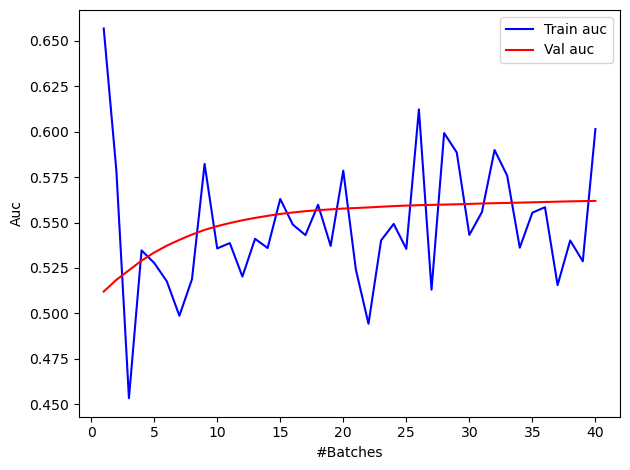

In [40]:
import os
if not os.path.exists('output'):
    os.mkdir('output')

import matplotlib.pyplot as plt

plt.plot(range(1, len(train_auc_hist)+1), train_auc_hist, color='blue', label='Train auc')
plt.plot(
    np.linspace(1, len(train_auc_hist), len(val_auc_hist)), 
    val_auc_hist, 
    color='red', 
    label='Val auc'
)
plt.legend(loc="best")
plt.xlabel('#Batches')
plt.ylabel('Auc')
plt.tight_layout()
plt.savefig('./output/fig-out-of-core.png', dpi=300)
plt.show()

定期保存

In [41]:
# import optimized pickle written in C for serializing and
# de-serializing a Python object
import _pickle as pkl

# dump to disk
pkl.dump(hashvec, open('output/hashvec.pkl', 'wb'))
pkl.dump(clf, open('output/clf-sgd.pkl', 'wb'))

# load from disk
hashvec = pkl.load(open('output/hashvec.pkl', 'rb'))
clf = pkl.load(open('output/clf-sgd.pkl', 'rb'))

df_test = pd.read_csv('./dataset/test.csv')
import scipy as sp
test_pred = sp.special.expit(clf.decision_function(hashvec.transform(df_test['Page content'])))

submission = pd.DataFrame({
    'Id': df_test['Id'],
    'Popularity': test_pred
})
submission.to_csv('output/submission.csv', index=False)
print('Test predictions saved to output/submission.csv')

Test predictions saved to output/submission.csv


修正精度

In [ ]:
import pandas as pd
from decimal import Decimal, ROUND_HALF_UP

df = pd.read_csv('output/submission.csv', usecols=['Id', 'Popularity'])

# Popularity 严格四舍五入到一位小数（ROUND_HALF_UP）
df['Popularity'] = df['Popularity'].map(
    lambda x: float(Decimal(str(x)).quantize(Decimal('0.0'), rounding=ROUND_HALF_UP))
).astype('float32')

# Id 保持整数（可选）
df['Id'] = df['Id'].astype('int64')

# 写出新文件
df.to_csv('output/submission_23.csv', index=False, float_format='%.1f')
print('saved -> output/submission_23.csv')

溫度縮放

In [45]:
import pandas as pd
import numpy as np
from scipy.special import expit, logit
from decimal import Decimal, ROUND_HALF_UP

# 讀原始提交
df = pd.read_csv('output/submission.csv')
col = 'Popularity' if 'Popularity' in df.columns else 'Predicted'

# 1) 溫度縮放：T<1 拉開（0.6~0.9 可調；0.7 通常效果明顯）
T = 0.005
p = df[col].to_numpy(np.float64)
p = np.clip(p, 1e-6, 1-1e-6)          # 防溢出
p_stretch = expit(logit(p) / T)       # 嚴格單調 → 排序不變（AUC 幾乎不變）

# 2) 四捨五入到一位小數（避免銀行家捨入）
def round1_half_up(x):
    return float(Decimal(str(x)).quantize(Decimal('0.0'), rounding=ROUND_HALF_UP))

p_1dp = np.array([round1_half_up(x) for x in p_stretch], dtype=np.float32)
p_1dp = np.clip(p_1dp, 0.0, 1.0)      # 邊界保險

# 3) 輸出：單精度 + 一位小數（減少並列但滿足賽制）
df[col] = p_1dp.astype(np.float32)
df[['Id', col]].to_csv('output/submission_23.csv', index=False, float_format='%.1f')
print('Saved -> output/submission_23.csv')


Saved -> output/submission_23.csv
